In [2]:
import os
import glob
import pydicom
import nibabel as nib
import pandas as pd
import numpy as np
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from tqdm import tqdm

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from utils.dcm_utils import *
from utils.nii_utils import *
from utils.train_utils import *
from utils.xray_utils import *

from PIL import Image

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, CenterCrop
import torchvision.transforms.functional as TF

In [8]:
# DATA_DIR = "/media/longyi/SSD9701/"
DATA_DIR = "/Volumes/SSD970/"
TRAIN_IMAGES_DIR = os.path.join(DATA_DIR, "train_images")
XRAY_IMAGES_DIR = os.path.join(DATA_DIR, "xray_images")
SEG_IMAGES_DIR = os.path.join(DATA_DIR, "segmentation_images")

In [9]:
seg_image_dirs = glob.glob(SEG_IMAGES_DIR + f"/**")
seg_image_dirs

['/Volumes/SSD970/segmentation_images/1.2.826.0.1.3680043.10633',
 '/Volumes/SSD970/segmentation_images/1.2.826.0.1.3680043.10921',
 '/Volumes/SSD970/segmentation_images/1.2.826.0.1.3680043.11827',
 '/Volumes/SSD970/segmentation_images/1.2.826.0.1.3680043.11988',
 '/Volumes/SSD970/segmentation_images/1.2.826.0.1.3680043.12281',
 '/Volumes/SSD970/segmentation_images/1.2.826.0.1.3680043.12292',
 '/Volumes/SSD970/segmentation_images/1.2.826.0.1.3680043.12833',
 '/Volumes/SSD970/segmentation_images/1.2.826.0.1.3680043.1363',
 '/Volumes/SSD970/segmentation_images/1.2.826.0.1.3680043.14267',
 '/Volumes/SSD970/segmentation_images/1.2.826.0.1.3680043.1480',
 '/Volumes/SSD970/segmentation_images/1.2.826.0.1.3680043.15206',
 '/Volumes/SSD970/segmentation_images/1.2.826.0.1.3680043.1542',
 '/Volumes/SSD970/segmentation_images/1.2.826.0.1.3680043.1573',
 '/Volumes/SSD970/segmentation_images/1.2.826.0.1.3680043.16092',
 '/Volumes/SSD970/segmentation_images/1.2.826.0.1.3680043.16919',
 '/Volumes/SSD

In [46]:
patient_ids = [path.split("/")[-1] for path in seg_image_dirs]
patient_ids

['1.2.826.0.1.3680043.10633',
 '1.2.826.0.1.3680043.10921',
 '1.2.826.0.1.3680043.11827',
 '1.2.826.0.1.3680043.11988',
 '1.2.826.0.1.3680043.12281',
 '1.2.826.0.1.3680043.12292',
 '1.2.826.0.1.3680043.12833',
 '1.2.826.0.1.3680043.1363',
 '1.2.826.0.1.3680043.14267',
 '1.2.826.0.1.3680043.1480',
 '1.2.826.0.1.3680043.15206',
 '1.2.826.0.1.3680043.1542',
 '1.2.826.0.1.3680043.1573',
 '1.2.826.0.1.3680043.16092',
 '1.2.826.0.1.3680043.16919',
 '1.2.826.0.1.3680043.17481',
 '1.2.826.0.1.3680043.17960',
 '1.2.826.0.1.3680043.18480',
 '1.2.826.0.1.3680043.1868',
 '1.2.826.0.1.3680043.18906',
 '1.2.826.0.1.3680043.18935',
 '1.2.826.0.1.3680043.18968',
 '1.2.826.0.1.3680043.19021',
 '1.2.826.0.1.3680043.19333',
 '1.2.826.0.1.3680043.19388',
 '1.2.826.0.1.3680043.20120',
 '1.2.826.0.1.3680043.20647',
 '1.2.826.0.1.3680043.20928',
 '1.2.826.0.1.3680043.21321',
 '1.2.826.0.1.3680043.21651',
 '1.2.826.0.1.3680043.2243',
 '1.2.826.0.1.3680043.23904',
 '1.2.826.0.1.3680043.24140',
 '1.2.826.0.1.36

In [119]:
dcm_df = pd.read_csv(os.path.join(DATA_DIR, 'meta_dcm_dataset.csv'))
dcm_df = dcm_df.set_index(['StudyInstanceUID'])
dcm_df = dcm_df[["InstanceNumber", "ImagePositionPatientZ"]]
dcm_df.head()

,InstanceNumber,ImagePositionPatientZ
StudyInstanceUID,,
1.2.826.0.1.3680043.17625,12,-36.480
1.2.826.0.1.3680043.17625,210,-160.230
1.2.826.0.1.3680043.17625,120,-103.980
1.2.826.0.1.3680043.17625,208,-158.980
1.2.826.0.1.3680043.17625,141,-117.105


In [120]:
seg_df = pd.DataFrame(columns=["StudyInstanceUID","InstanceNumber", "seg_idx", "ImagePositionPatientZ"]).set_index("StudyInstanceUID")
seg_df.head()

,InstanceNumber,seg_idx,ImagePositionPatientZ
StudyInstanceUID,,,


In [121]:
patient_df = dcm_df.loc["1.2.826.0.1.3680043.1363", ["InstanceNumber","ImagePositionPatientZ"]].sort_values(by='InstanceNumber')
patient_df

,InstanceNumber,ImagePositionPatientZ
StudyInstanceUID,,
1.2.826.0.1.3680043.1363,1,54.0
1.2.826.0.1.3680043.1363,2,55.0
1.2.826.0.1.3680043.1363,3,56.0
1.2.826.0.1.3680043.1363,4,57.0
1.2.826.0.1.3680043.1363,5,58.0
...,...,...
1.2.826.0.1.3680043.1363,195,248.0
1.2.826.0.1.3680043.1363,196,249.0
1.2.826.0.1.3680043.1363,197,250.0


In [122]:
for patient_id in tqdm(patient_ids):
    patient_df = dcm_df.loc[patient_id, ["InstanceNumber","ImagePositionPatientZ"]].sort_values(by='InstanceNumber')
    slice_total = len(patient_df)
    is_flip = (patient_df.iloc[1]['ImagePositionPatientZ'] - patient_df.iloc[0]['ImagePositionPatientZ']) < 0
    seg_idx = np.arange(slice_total)
    if is_flip:
        seg_idx = slice_total - seg_idx - 1
    patient_df['seg_idx'] = seg_idx
    seg_df = pd.concat([seg_df, patient_df])
seg_df.head()

100%|██████████| 87/87 [00:01<00:00, 69.58it/s]


,InstanceNumber,seg_idx,ImagePositionPatientZ
StudyInstanceUID,,,
1.2.826.0.1.3680043.10633,1,428,314.099976
1.2.826.0.1.3680043.10633,2,427,313.599976
1.2.826.0.1.3680043.10633,3,426,313.099976
1.2.826.0.1.3680043.10633,4,425,312.599976
1.2.826.0.1.3680043.10633,5,424,312.099976


In [125]:
len(seg_df)

29832

In [138]:
slice_df = seg_df.iloc[0]
slice_df

InstanceNumber                    1
seg_idx                         428
ImagePositionPatientZ    314.099976
Name: 1.2.826.0.1.3680043.10633, dtype: object

In [139]:
slice_df.name

'1.2.826.0.1.3680043.10633'

In [140]:
slice_df.InstanceNumber

1

In [126]:
seg_df.to_csv("meta_segment_idx.csv")

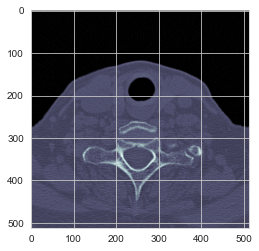

In [41]:
dcm_img = read_dcm(os.path.join(TRAIN_IMAGES_DIR, UID), 328)
plt.imshow(dcm_img, cmap='bone')

In [10]:
seg_img_dir = seg_image_dirs[0]
seg_img_dir

'/Volumes/SSD970/segmentation_images/1.2.826.0.1.3680043.10633'

In [147]:
from utils.dcm_utils import read_dcm
class SegDataset(Dataset):
    def __init__(self, df, image_dir, seg_dir, transform=None, target_transform=None):
        self.df = df
        self.image_dir = image_dir
        self.seg_dir = seg_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        slice_df = self.df.iloc[idx]
        UID = slice_df.name

        slice_img = read_dcm(os.path.join(TRAIN_IMAGES_DIR, UID), slice_df.InstanceNumber)
        label_img = Image.open(os.path.join(self.seg_dir, UID, f"{slice_df.seg_idx}.png"))
        label_img = np.round(np.asarray(label_img, np.uint8) // 32)
        if self.transform:
            slice_img = self.transform(slice_img)
        if self.target_transform:
            label_img = self.target_transform(label_img)

        return slice_img, label_img

dataset = SegDataset(seg_df, TRAIN_IMAGES_DIR, SEG_IMAGES_DIR)


47075
(512, 512)
0
5


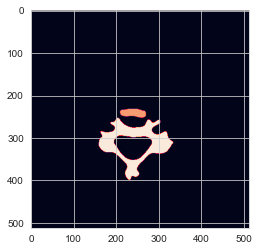

In [155]:
img, label = dataset[250]
print(label.sum())
print(img.shape)
print(label.min())
print(label.max())
plt.imshow(label)


In [156]:
class ResidualBlock(nn.Module):
    def __init__(self, h):
        super().__init__()

        self.layers = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(2*h, h, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(h, h, kernel_size=3, padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(h, 2*h, kernel_size=1)
        )
    def forward(self, x):
        out = self.layers(x)
        out += x
        return out

In [157]:
class SegModel(nn.Module):
    def __init__(self, h, num_residual=8):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(1, 2*h, kernel_size=3, padding='same'),
            *[
                ResidualBlock(h) for _ in range(num_residual)
            ],
            nn.ReLU(inplace=True),
            nn.Conv2d(2*h, 1, kernel_size=1)
        )

    def forward(self, x):
        return self.layers(x)


In [158]:
model = SegModel(128, num_residual=8)

input = torch.randn(1, 1, 512, 512)
model(input).shape

torch.Size([1, 1, 512, 512])

In [ ]:
dataloader = DataLoader(dataset, )